In [3]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import py_func.experiment_func as expf
import glob
import os
import re
cv2.__version__

'3.4.1'

In [4]:
img_dir_path='./grayimg/mnist_1_50'
movie_path='./grayimg/movie/mnist_1_50_nonblack_fps0.5_dr0.4.mp4'
fps=0.5
dr = 0.4
expf.grayjpgs_to_mp4_ver3(img_dir_path,movie_path,fps,False,dr)

In [37]:
def grayjpgs_to_mp4_ver3(img_dir_path,movie_path,fps,first_blackimg_true,down_ratio):
    """
    create a movie by appending images in folder
    In ver2, you can add a black image at first.
    You can resize images and 0-pad.
    """
    #画像ディレクトリ内の画像を整列
    img_array = []
    filepath_list=glob.glob(img_dir_path + "/*.jpg")
    filename_list=[]
    for filepath in filepath_list:
        dir_path, filename = os.path.split(filepath)
        filename_list.append(filename)
    
    filename_list_sorted = sorted(filename_list, key=lambda x:int((re.search(r"[0-9]+", x)).group(0)))
    
    #画像をリストに格納
    for filename_sorted in filename_list_sorted:
        img = cv2.imread(img_dir_path + '/' + filename_sorted,cv2.IMREAD_GRAYSCALE)
        img_array.append(img)
    #print(len(img_array))
    height,width = img_array[0].shape
    size = (width,height)
    
    #元画像を縮小
    if (down_ratio != None):
        for i in range(len(img_array)):
            img_tmp = img_array[i]
            pad_width = int((width * (1 / down_ratio) - width) / 2)
            pad_height = int((height * (1 / down_ratio) - height) / 2)
            img_tmp = cv2.copyMakeBorder(img_tmp, pad_width, pad_width, pad_height, pad_height, cv2.BORDER_CONSTANT, 0)
            img_tmp = cv2.resize(img_tmp, size)
            img_array[i] = img_tmp


    #黒画像を先頭に追加
    if first_blackimg_true==True:
        img_black = np.zeros((height ,width), np.uint8)
        img_array = [img_black] + img_array

    out = cv2.VideoWriter(movie_path,cv2.VideoWriter_fourcc(*'MP4V'),fps,size,False)
    for i in range(len(img_array)):
        out.write(img_array[i])

    out.release()

In [2]:
img_dir_path='./grayimg/mnist_1_2000'
movie_path='./grayimg/movie/mnist_1_2000_nonblack_fps0.5_dr0.4.mp4'
fps=0.5
dr = 0.4
expf.grayjpgs_to_mp4_ver3(img_dir_path,movie_path,fps,False,dr)

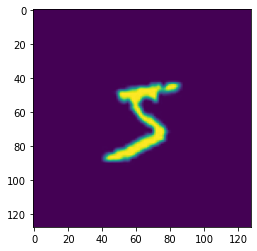

In [23]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [14]:
#fps0.25できないので0.5で同じ画像を二枚つなげる
def grayjpgs_to_mp4_ver2(img_dir_path,movie_path,fps,first_blackimg_true):
    """
    create a movie by appending images in folder
    In ver2, you can add a black image at first.
    """
    
    img_array = []
    filepath_list=glob.glob(img_dir_path + "/*.jpg")
    filename_list=[]
    for filepath in filepath_list:
        dir_path, filename = os.path.split(filepath)
        filename_list.append(filename)
    
    filename_list_sorted = sorted(filename_list, key=lambda x:int((re.search(r"[0-9]+", x)).group(0)))
    
    for filename_sorted in filename_list_sorted:
        img = cv2.imread(img_dir_path + '/' + filename_sorted,cv2.IMREAD_GRAYSCALE)
        img_array.append(img)
    print(len(img_array))
    height,width = img_array[0].shape
    size = (width,height)
    
    #黒画像を先頭に追加
    if first_blackimg_true==True:
        img_black = np.zeros((height ,width), np.uint8)
        img_array = [img_black] + img_array

    out = cv2.VideoWriter(movie_path,cv2.VideoWriter_fourcc(*'MP4V'),fps,size,False)
    #fpsが半分に
    for i in range(len(img_array)):
        out.write(img_array[i])
        out.write(img_array[i])

    out.release()
    
img_dir_path='./grayimg/mnist_1_1000'
movie_path='./grayimg/movie/mnist_1000_nonblack_fps0.25.mp4'
fps=0.5
grayjpgs_to_mp4_ver2(img_dir_path,movie_path,fps,False)

1000


In [25]:
def cam_get_data(num,camera_num,sleep_time_first_true,sleep_time_first,sleep_time,dataset_path,miss_size,miss_data,byte_num,write_row):
    """
    get data from a camera
    After sleep_time_first, camera gets a data for every sleep_time(laptime in fact)
    First data is discarded, because first laptime is usually longer than others. 
    """
    cap=cv2.VideoCapture(camera_num)
    if cap.isOpened():
        f=open(dataset_path,'wb')
        
        t_start=time.time()
        
        for img_number in range(num):
            t1=time.time()
            
            #最初の休止
            if (sleep_time_first_true==True) and (img_number==0):
                time.sleep(sleep_time_first)

            

            #画像取得
            ret,frame=cap.read()
            
            t_get=time.time()
            get_time=t_get-t1
            print(f'{get_time}取得時間')
        
            if ret==False:
                print(f'{img_number+1}枚目：取得失敗')
            
                #miss_dataをmiss_size回書き込み
                for _ in range(miss_size):
                    tmp=miss_data
                
                    if (byte_num==1):
                        tmp=tmp.to_bytes(1,'little')
                    else:
                        tmp=tmp.to_bytes(4,'little')
                    f.write(tmp)
                
                continue
            
            else:
                
                #一行書き込み
                for i in range(len(frame[write_row])):
                    tmp=int(frame[write_row][i][0])

                    if (byte_num==1):
                        tmp=tmp.to_bytes(1,'little')
                    else:
                        tmp=tmp.to_bytes(4,'little')
                    f.write(tmp)
            
            #休止
            time.sleep(sleep_time)

            t2=time.time()
            laptime=t2-t1
            print(f'ラップタイム{laptime}秒')
            
        t_end=time.time()
        alltime=t_end-t_start
        print(f'全画像取得までの時間{alltime}秒')
        f.close()
        
    cap.release()

In [26]:
#データセット書き込みパス
dataset_path='./dat/experimentdat/exp_m_7.dat'
cam_get_data(10,0,False,0,2,dataset_path,640,0,1,240)

0.40001344680786133取得時間
ラップタイム2.400861978530884秒
0.0取得時間
ラップタイム2.001016855239868秒
0.0取得時間
ラップタイム2.0010061264038086秒
0.0取得時間
ラップタイム2.002000570297241秒
0.0取得時間
ラップタイム2.0010101795196533秒
0.0取得時間
ラップタイム2.0014140605926514秒
0.0取得時間
ラップタイム2.001999616622925秒
0.0取得時間
ラップタイム2.0000052452087402秒
0.0取得時間
ラップタイム2.001007080078125秒
0.0取得時間
ラップタイム2.001655340194702秒
全画像取得までの時間20.4119770526886秒


In [16]:
nt = time.time()

In [17]:
type(nt)

float

In [13]:
import cv2
import glob
import re
import os
import numpy as np

def grayjpgs_to_mp4_ver2(img_dir_path,movie_path,fps,first_blackimg_true):
    """
    create a movie by appending images in folder
    """
    
    img_array = []
    filepath_list=glob.glob(img_dir_path + "/*.jpg")
    filename_list=[]
    for filepath in filepath_list:
        dir_path, filename = os.path.split(filepath)
        filename_list.append(filename)
    
    filename_list_sorted = sorted(filename_list, key=lambda x:int((re.search(r"[0-9]+", x)).group(0)))
    
    for filename_sorted in filename_list_sorted:
        img = cv2.imread(img_dir_path + '/' + filename_sorted,cv2.IMREAD_GRAYSCALE)
        img_array.append(img)

    height,width = img_array[0].shape
    size = (width,height)
    
    #黒画像を先頭に追加
    if first_blackimg_true==True:
        img_black = np.zeros((height ,width), np.uint8)
        img_array = [img_black] + img_array

    out = cv2.VideoWriter(movie_path,cv2.VideoWriter_fourcc(*'MP4V'),fps,size,False)
    for i in range(len(img_array)):
        out.write(img_array[i])

    out.release()

In [14]:
img_dir_path='./grayimg/mnist_test'
movie_path='./grayimg/movie/mnist_1_2000_first_black.mp4'
fps=1
grayjpgs_to_mp4(img_dir_path,movie_path,fps,True)

In [18]:
img_dir_path='./grayimg/mnist_test'
movie_path='./grayimg/movie/mnist_1_2000.mp4'
fps=10
mov.grayjpgs_to_mp4(img_dir_path,movie_path,fps)

True
(480, 640, 3)
<class 'numpy.uint8'>
<class 'int'>


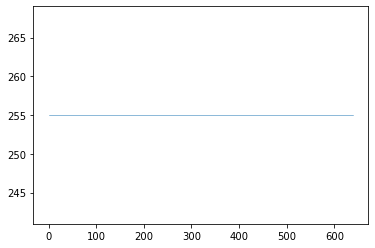

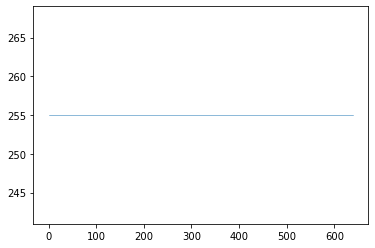

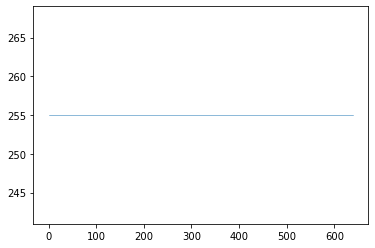

(480, 640, 3)
<class 'numpy.uint8'>
<class 'int'>


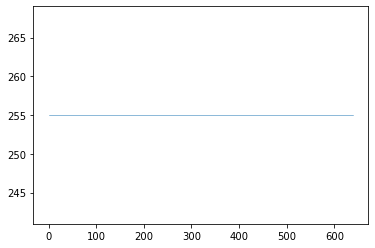

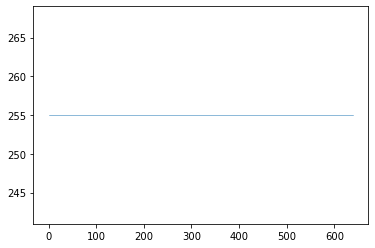

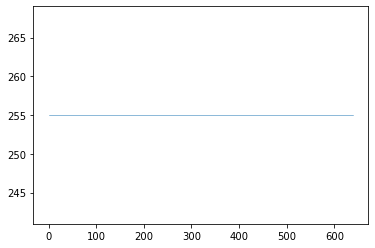

(480, 640, 3)
<class 'numpy.uint8'>
<class 'int'>


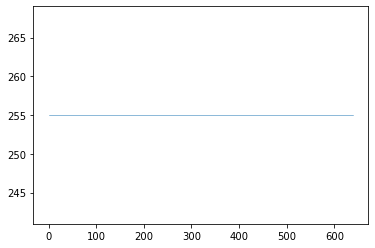

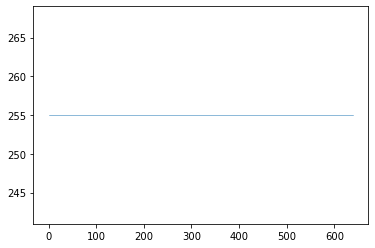

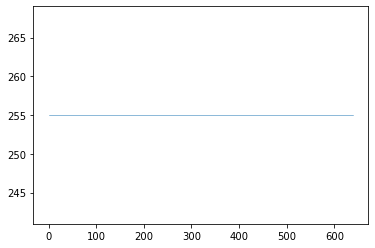

In [4]:
cap=cv2.VideoCapture(0)
print(cap.isOpened())
if cap.isOpened():
    for _ in range(3):
        time.sleep(0.1)
        ret,frame=cap.read()
        windowsize = (800, 600)
        if ret==False:
            print("miss")
            continue
        else:
            print(frame.shape)
#             for i in range(len(frame[0][0])):
#                 plt.plot(range(0,size), dat[i],linewidth=1)
#                 print(frame[0][0][i])
                
            r=[]
            g=[]
            b=[]
            for i in range(len(frame[0])):
                r.append(frame[200][i][0])
                g.append(frame[200][i][1])
                b.append(frame[200][i][2])
            print(type(frame[200][0][0]))
            tmp=int(frame[200][0][0])
            print(type(tmp))
            r=np.array(r)
            g=np.array(g)
            b=np.array(b)
            plt.plot(range(0,len(r)), r,linewidth=0.5)
            plt.show()
            plt.plot(range(0,len(g)), g,linewidth=0.5)
            plt.show()
            plt.plot(range(0,len(b)), b,linewidth=0.5)
            plt.show()


        frame = cv2.resize(frame, windowsize)
        #time.sleep(1)
        cv2.imshow("Flame",frame)
#         if cv2.waitKey(3000)&0xFF == ord('q'):
#             break

cap.release()
cv2.destroyAllWindows()

In [2]:
import cv2
import time

# VideoCapture オブジェクトを取得します
capture = cv2.VideoCapture(0)
print(type(capture))
print(capture.isOpened())
# print(capture.set)
for i in range(5):
    ret, frame = capture.read()
    time.sleep(1)
    if ret:
        print(type(frame))
        cv2.imshow('image',frame)
    else:
        print('miss')
        print(type(frame))


capture.release()
cv2.destroyAllWindows()

<class 'cv2.VideoCapture'>
False
miss
<class 'NoneType'>
miss
<class 'NoneType'>
miss
<class 'NoneType'>
miss
<class 'NoneType'>
miss
<class 'NoneType'>


In [1]:
import numpy as np
import cv2

capture = cv2.VideoCapture('mnist_test.mp4')

for i in range(5):
    ret, frame = capture.read()
    if ret:
        print(type(frame))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('image',gray)
    else:
        print('miss')

capture.release()
cv2.destroyAllWindows()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
